# EN3160 Assignment 3 on Neural Networks {-}

Instructed by Dr. Ranga Rodrigo

Done by Warren Jayakumar

Repository: [Warren-SJ/Image-Processing-Exercises](https://github.com/Warren-SJ/Image-Processing-Exercises)

\tableofcontents
\newpage

# Introduction {-}

This assignment is focused on implementing neural networks for image classification. This is done by using:
1. Our own neural network implementation
2. An implementation of LeNet-5
3. An implementation of ResNet-18

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchinfo import summary
import matplotlib.pyplot as plt
import gc

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

\newpage

# Our own architecture

In [3]:
transform = transforms.Compose ([ transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5) , (0.5, 0.5, 0.5))])
batch_size = 32
trainset = torchvision.datasets.CIFAR10(root= './data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root= './data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Single Layer

In [4]:
Din = 3*32*32 # Input size (flattened CIFAR=10 image size)
K = 10 # Output size (number of classes in CIFAR=10)
std = 1e-5
# Initialize weights and biases
w = torch.randn(Din, K, device=device, dtype=torch.float, requires_grad=True) * std
b = torch.randn(K, device=device, dtype=torch.float, requires_grad=True)
# Hyperparameters
iterations = 20
lr = 2e-6 # Learning rate
lr_decay = 0.9 # Learning rate decay
reg = 0 # Regularization
loss_history = [ ]

In [5]:
for t in range(iterations):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Get inputs and labels
        inputs, labels = data
        Ntr = inputs.shape[0]  # Batch size
        x_train = inputs.view(Ntr, -1).to(device)  # Flatten input to (Ntr, Din)
        y_train_onehot = nn.functional.one_hot(labels, K).float().to(device)  # Convert labels to one-hot

        # Forward pass
        y_pred = x_train.mm(w) + b  # Output layer activation

        # Loss calculation (Mean Squared Error with regularization)
        loss = (1/Ntr) * torch.sum((y_pred - y_train_onehot) ** 2) + reg * torch.sum(w ** 2)
        running_loss += loss.item()

        # Backpropagation
        dy_pred = (2.0 / Ntr) * (y_pred - y_train_onehot)
        dw = x_train.t().mm(dy_pred) + reg * w
        db = dy_pred.sum(dim=0)

        # Parameter update
        w = w - lr * dw
        b = b - lr * db

    loss_history.append(running_loss / len(trainloader))
    print(f"Epoch {t + 1} / {iterations}, Loss: {running_loss / len(trainloader)}")

    # Learning rate decay
    lr *= lr_decay

Epoch 1 / 20, Loss: 6.309315636916109
Epoch 2 / 20, Loss: 5.549143583898124
Epoch 3 / 20, Loss: 5.214354223878583
Epoch 4 / 20, Loss: 5.0211618167806416
Epoch 5 / 20, Loss: 4.890955400405903
Epoch 6 / 20, Loss: 4.794787223111798
Epoch 7 / 20, Loss: 4.718993186798144
Epoch 8 / 20, Loss: 4.65812322838674
Epoch 9 / 20, Loss: 4.6082750625207645
Epoch 10 / 20, Loss: 4.56568484968355
Epoch 11 / 20, Loss: 4.529754013109116
Epoch 12 / 20, Loss: 4.498623353734812
Epoch 13 / 20, Loss: 4.472161533431373
Epoch 14 / 20, Loss: 4.448784878829009
Epoch 15 / 20, Loss: 4.427916666520229
Epoch 16 / 20, Loss: 4.409813799769621
Epoch 17 / 20, Loss: 4.394613589068978
Epoch 18 / 20, Loss: 4.380091812239956
Epoch 19 / 20, Loss: 4.368443265299879
Epoch 20 / 20, Loss: 4.356881305337028


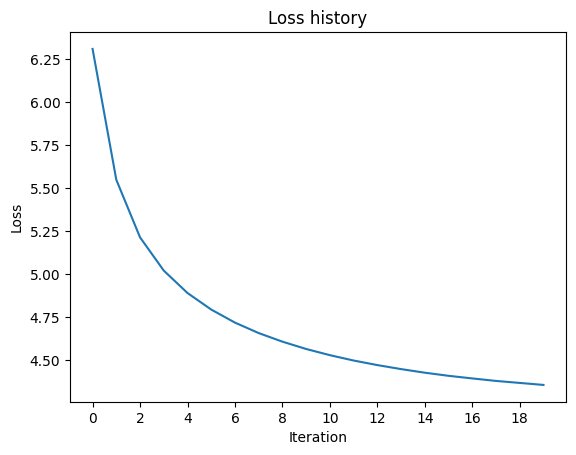

In [6]:
plt.plot(loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.xticks(range(0, iterations, 2))
plt.title('Loss history')
plt.show()

In [7]:
def calculate_accuracy(dataloader: torch.utils.data.DataLoader, w: torch.Tensor, b: torch.Tensor) -> float:
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            N = inputs.shape[0]
            x = inputs.view(N, -1)
            y = x.mm(w) + b
            predicted = torch.argmax(y, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [8]:
train_accuracy = calculate_accuracy(trainloader, w, b)
test_accuracy = calculate_accuracy(testloader, w, b)

print(f"Train accuracy: {train_accuracy:.2f}%")
print(f"Test accuracy: {test_accuracy:.2f}%")

Train accuracy: 16.13%
Test accuracy: 15.91%


We see above that the performance is extremely poor. This is because the model has no non-linearity. We will add a non-linearity to the model and see if the performance improves. This is added using a hidden layer with sigmoid activation

In [9]:
del w, b, x_train, y_train_onehot, y_pred, loss, dy_pred, dw, db
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

## Adding Non-linearity

In [10]:
# This implementation is not efficient and is only for educational purposes. For real-world applications, use PyTorch's built-in functions and classes. ThiS may fail
# as memory usage increases with the number of iterations.

Din = 3*32*32 # Input size (flattened CIFAR=10 image size)
K = 10 # Output size (number of classes in CIFAR=10)
std = 1e-5
# Initialize weights and biases
w1 = torch.randn(Din, 100, device=device, requires_grad=True)
b1 = torch.zeros(100, device=device, requires_grad=True)
w2 = torch.randn(100, K, device=device, requires_grad=True)
b2 = torch.zeros(K, device=device, requires_grad=True)
# Hyperparameters
iterations = 10 # Reduced as memory usage increases
lr = 2e-6 # Learning rate
lr_decay = 0.9 # Learning rate decay
reg = 0 # Regularization
loss_history = [ ]

In [11]:
for t in range(iterations):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Get inputs and labels
        inputs, labels = data
        Ntr = inputs.shape[0]  # Batch size
        x_train = inputs.view(Ntr, -1).to(device)  # Flatten input to (Ntr, Din)
        y_train_onehot = nn.functional.one_hot(labels, K).float().to(device)  # One-hot labels

        # Forward pass
        hidden = x_train.mm(w1) + b1
        hidden_activation = torch.sigmoid(hidden)  # Sigmoid activation
        logits = hidden_activation.mm(w2) + b2  # Logits before softmax

        # Compute softmax probabilities
        max_logits = torch.max(logits, dim=1, keepdim=True)[0]
        exp_logits = torch.exp(logits - max_logits)
        probs = exp_logits / torch.sum(exp_logits, dim=1, keepdim=True)

        # Cross-Entropy Loss with L2 regularization
        epsilon = 1e-12  # Small value to prevent log(0)
        log_probs = torch.log(probs + epsilon)
        loss = -torch.sum(y_train_onehot * log_probs) / Ntr
        loss += reg * (torch.sum(w1 ** 2) + torch.sum(w2 ** 2))
        running_loss += loss.item()

        # Backpropagation
        dlogits = (probs - y_train_onehot) / Ntr 

        # Gradients for parameters of the second layer
        dw2 = hidden_activation.t().mm(dlogits) + reg * w2
        db2 = dlogits.sum(dim=0)

        # Backpropagate through ReLU activation
        dhidden_activation = dlogits.mm(w2.t())
        dhidden = dhidden_activation * hidden_activation * (1 - hidden_activation)  # Derivative of sigmoid

        # Gradients for parameters of the first layer
        dw1 = x_train.t().mm(dhidden) + reg * w1
        db1 = dhidden.sum(dim=0)

        # Parameter updates
        w2 = w2 - lr * dw2
        b2 = b2 - lr * db2
        w1 = w1 - lr * dw1
        b1 = b1 - lr * db1

    loss_history.append(running_loss / len(trainloader))
    print(f"Epoch {t+1} / {iterations}, Loss: {running_loss / len(trainloader)}")

    # Learning rate decay
    lr *= lr_decay

Epoch 1 / 10, Loss: 8.77062671060983
Epoch 2 / 10, Loss: 8.7613635920441
Epoch 3 / 10, Loss: 8.753118033601318
Epoch 4 / 10, Loss: 8.745599119463412
Epoch 5 / 10, Loss: 8.740169318913651
Epoch 6 / 10, Loss: 8.734824682761673
Epoch 7 / 10, Loss: 8.729062423291149
Epoch 8 / 10, Loss: 8.724829464178397
Epoch 9 / 10, Loss: 8.721024848525522
Epoch 10 / 10, Loss: 8.717586632043371


It is observed that the loss values decrease on each iteration

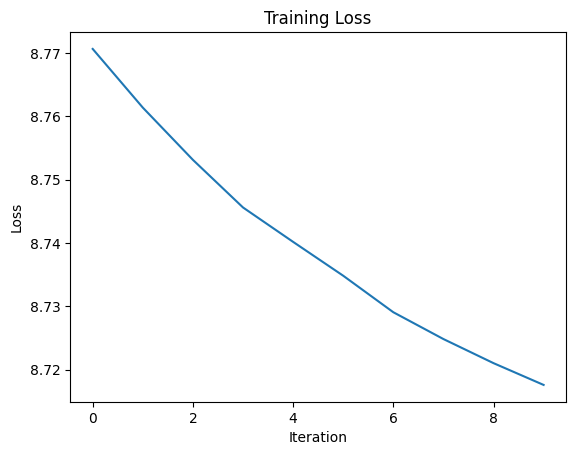

In [12]:
plt.plot(loss_history)
plt.xlabel('Iteration')
plt.xticks(range(0, iterations, 2))
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [13]:
def calculate_accuracy(dataloader: torch.utils.data.DataLoader, w1: torch.Tensor, b1: torch.Tensor, w2: torch.Tensor, b2: torch.Tensor) -> float:
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            N = inputs.shape[0]
            x = inputs.view(N, -1)
            hidden = torch.sigmoid(x.mm(w1) + b1)
            y = hidden.mm(w2) + b2
            predicted = torch.argmax(y, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [14]:
train_accuracy = calculate_accuracy(trainloader, w1, b1, w2, b2)
test_accuracy = calculate_accuracy(testloader, w1, b1, w2, b2)

print(f"Train accuracy: {train_accuracy:.2f}%")
print(f"Test accuracy: {test_accuracy:.2f}%")

Train accuracy: 10.71%
Test accuracy: 10.24%


In [15]:
del w1, b1, w2, b2, x_train, y_train_onehot, hidden, hidden_activation, logits, probs, log_probs, loss, dlogits, dw2, db2, dhidden_activation, dhidden, dw1, db1
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

## A more efficient implementation

In [16]:
Din = 3*32*32 # Input size (flattened CIFAR=10 image size)
K = 10 # Output size (number of classes in CIFAR=10)
lr = 1e-3 # Learning rate
reg = 1e-5 # Regularization strength

In [17]:
class NeuralNetwork(nn.Module):
    def __init__(self, Din, H, Dout):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(Din, H)
        self.linear2 = nn.Linear(H, Dout)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = torch.sigmoid(self.linear1(x))
        x = self.linear2(x)
        return x

We will define a function for training and testing the model

In [18]:
def train(model:nn.Module,
          trainloader:torch.utils.data.DataLoader,
          testloader:torch.utils.data.DataLoader,
          iterations:int,
          optimizer:torch.optim.Optimizer,
          loss_fn:torch.nn.Module,
          device: torch.device) -> tuple:
    train_accuracy_hist = [ ]
    test_accuracy_hist = [ ]
    train_loss_hist = [ ]
    test_loss_hist = [ ]
    for t in range(iterations):
        model.train()
        accuracy = 0
        running_loss = 0.0
        for _, data in enumerate(trainloader, 0):
            inputs, labels = data
            x_train, y_train = inputs.to(device), labels.to(device)
            y_pred = model(x_train)
            loss_val = loss_fn(y_pred, y_train)
            running_loss += loss_val.item()
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
            _, predicted = torch.max(y_pred, 1)
            accuracy += (predicted == y_train).sum().item()
        train_accuracy_hist.append(accuracy / len(trainloader.dataset))
        train_loss_hist.append(running_loss / len(trainloader))
        model.eval()
        with torch.inference_mode():
            accuracy = 0
            running_loss = 0.0
            for i, data in enumerate(testloader, 0):
                inputs, labels = data
                x_test, y_test = inputs.to(device), labels.to(device)
                y_pred = model(x_test)
                loss_val = loss_fn(y_pred, y_test)
                running_loss += loss_val.item()
                _, predicted = torch.max(y_pred, 1)
                accuracy += (predicted == y_test).sum().item()
            test_accuracy_hist.append(accuracy / len(testloader.dataset))
            test_loss_hist.append(running_loss / len(testloader))
        print(f"Epoch {t + 1} / {iterations}, Train Loss: {train_loss_hist[-1]}, Test Loss: {test_loss_hist[-1]}, Train Accuracy: {train_accuracy_hist[-1]}, Test Accuracy: {test_accuracy_hist[-1]}")
    return train_accuracy_hist, test_accuracy_hist, train_loss_hist, test_loss_hist

In [19]:
model = NeuralNetwork(Din, 100, K).to(device)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)
iterations = 20

In [20]:
train_accuracy_hist, test_accuracy_hist, train_loss_hist, test_loss_hist = train(model, trainloader, testloader, iterations, optimizer, loss, device)

Epoch 1 / 20, Train Loss: 1.756354550177366, Test Loss: 1.675218096556374, Train Accuracy: 0.3876, Test Accuracy: 0.4225
Epoch 2 / 20, Train Loss: 1.6315957853142755, Test Loss: 1.6355849732987036, Train Accuracy: 0.43504, Test Accuracy: 0.4294
Epoch 3 / 20, Train Loss: 1.5729634079960624, Test Loss: 1.5945421346841149, Train Accuracy: 0.45582, Test Accuracy: 0.4499
Epoch 4 / 20, Train Loss: 1.5299214721488708, Test Loss: 1.577893341692111, Train Accuracy: 0.47008, Test Accuracy: 0.4528
Epoch 5 / 20, Train Loss: 1.4881449486686111, Test Loss: 1.5864154199441782, Train Accuracy: 0.48602, Test Accuracy: 0.4497
Epoch 6 / 20, Train Loss: 1.4560639447915729, Test Loss: 1.561577286583166, Train Accuracy: 0.49772, Test Accuracy: 0.4648
Epoch 7 / 20, Train Loss: 1.425123206713378, Test Loss: 1.5540121016791835, Train Accuracy: 0.50922, Test Accuracy: 0.4663
Epoch 8 / 20, Train Loss: 1.3972938078683839, Test Loss: 1.5651529760787282, Train Accuracy: 0.51956, Test Accuracy: 0.4651
Epoch 9 / 20, 

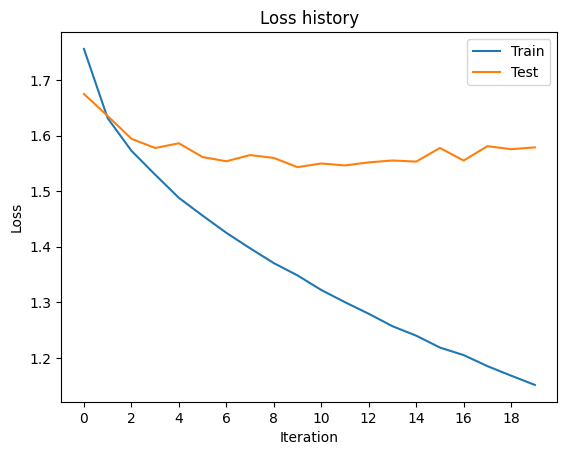

In [21]:
plt.plot(train_loss_hist, label='Train')
plt.plot(test_loss_hist, label='Test')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.xticks(range(0, iterations, 2))
plt.title('Loss history')
plt.legend()
plt.show()

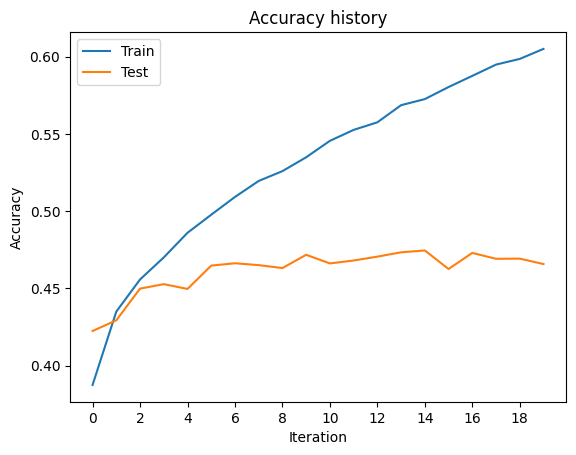

In [22]:
plt.plot(train_accuracy_hist, label='Train')
plt.plot(test_accuracy_hist, label='Test')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.xticks(range(0, iterations, 2))
plt.title('Accuracy history')
plt.legend()
plt.show()

In [23]:
def calculate_accuracy(model: nn.Module, dataloader: torch.utils.data.DataLoader) -> float:
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            x, y = inputs.to(device), labels.to(device)
            outputs = model(x)
            _, predicted = torch.max(outputs, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    return 100 * correct / total

In [24]:
train_accuracy = calculate_accuracy(model, trainloader)
test_accuracy = calculate_accuracy(model, testloader)

print(f"Train accuracy: {train_accuracy:.2f}%")
print(f"Test accuracy: {test_accuracy:.2f}%")

Train accuracy: 62.63%
Test accuracy: 46.58%


We see that the accuracy is still very low as was in our custom implementation As at the time of writing, according to [paperswithcode.com](https://paperswithcode.com/sota/image-classification-on-cifar-10), the best accuracy on CIFAR-10 is $99.5\%$. This is achieved by a model called ViT-H/14 which is a vision transformer. Another thing to note is that the model is beginning to overfit after just 3 epochs. This is because the model is too simple and is not able to learn the complex patterns in the data.

In [25]:
del model, trainloader, testloader, train_accuracy_hist, test_accuracy_hist, train_loss_hist, test_loss_hist
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

\newpage

# LeNet-5

Here we will be implementint LeNet-5 architecture for MNIST dataset.

In [26]:
batch_size = 32

In [27]:
trainset_mnist = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
trainloader_mnist = torch.utils.data.DataLoader(trainset_mnist, batch_size=batch_size, shuffle=True)
testset_mnist = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
testloader_mnist = torch.utils.data.DataLoader(testset_mnist, batch_size=batch_size, shuffle=False)
classes = tuple(str(i) for i in range(10))

#### Architecture {-}

In [ ]:
class LeNet(nn.Module):
    def __init__(self, input_size, input_channels, output_size):
        super(LeNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channels, 6, 5),
            nn.ReLU(),
            nn.AvgPool2d(2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.AvgPool2d(2)
        )

        conv_output_size = ((input_size - 4) // 2 - 4) // 2
        self.classifier = nn.Sequential(
            nn.Linear(16 * conv_output_size * conv_output_size, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, output_size)
        )

    def forward(self, x):
        y = self.conv1(x)
        y = self.conv2(y)
        y = y.view(y.size(0), -1)
        y = self.classifier(y)
        return y

In [29]:
lenet_model = LeNet(input_size = 28, input_channels = 1, output_size = 10).to(device)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(lenet_model.parameters(), lr=0.001)
iterations = 5 # Sufficient since MNIST is a simple dataset

In [30]:
train_accuracy_hist, test_accuracy_hist, train_loss_hist, test_loss_hist = train(lenet_model, trainloader_mnist, testloader_mnist, iterations, optimizer, loss, device)

Epoch 1 / 5, Train Loss: 0.23917823472023012, Test Loss: 0.07399401403372191, Train Accuracy: 0.9249833333333334, Test Accuracy: 0.975
Epoch 2 / 5, Train Loss: 0.0732845237663947, Test Loss: 0.051476614563517605, Train Accuracy: 0.9772, Test Accuracy: 0.9839
Epoch 3 / 5, Train Loss: 0.051611536767209566, Test Loss: 0.06785203708740607, Train Accuracy: 0.9835833333333334, Test Accuracy: 0.9786
Epoch 4 / 5, Train Loss: 0.0411661645629288, Test Loss: 0.04024723509087889, Train Accuracy: 0.9866833333333334, Test Accuracy: 0.9874
Epoch 5 / 5, Train Loss: 0.03360636993950078, Test Loss: 0.04080141513728717, Train Accuracy: 0.9893833333333333, Test Accuracy: 0.9875


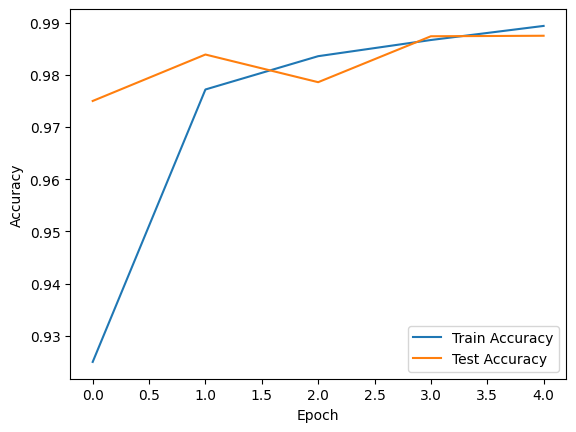

In [31]:
plt.plot(train_accuracy_hist, label='Train Accuracy')
plt.plot(test_accuracy_hist, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

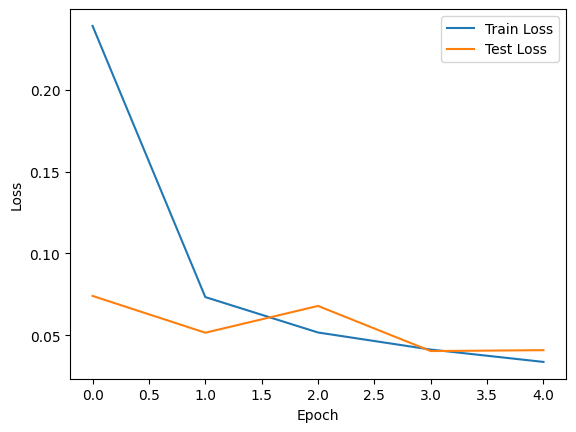

In [32]:
plt.plot(train_loss_hist, label='Train Loss')
plt.plot(test_loss_hist, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [33]:
train_accuracy = calculate_accuracy(lenet_model, trainloader_mnist)
test_accuracy = calculate_accuracy(lenet_model, testloader_mnist)

print(f"Train accuracy: {train_accuracy:.2f}%")
print(f"Test accuracy: {test_accuracy:.2f}%")

Train accuracy: 99.12%
Test accuracy: 98.75%


Observing the plots of loss and accuracy, we can see that the model is performing well. As expected, the train and test losses are decreasing and the train and test accuracies are increasing with each epoch. After 5 epochs, the model was able to achieve a test accuracy of $98.75\%$. This is easy to achieve as the MNIST dataset is simple and LeNet-5 is a good architecture for this dataset. 5 epochs were used since the model began to overfit after this point.

\newpage

# Implementing ResNet-18

In this section, we will implement ResNet-18 architecture for classifying the hymenoptera dataset consiting of images of ants and bees. In this first section, we will be finetuning the netwrok where we will be using a pre-trained model and retraining it on the hymenoptera dataset. In the second section, we will be using the network as a feature extractor where we freeze the weights of the network and only train the final classification layer.

## Finetuning the network

In [34]:
resnet_model = torchvision.models.resnet18(weights = 'IMAGENET1K_V1').to(device) # These are the default weights
batch_size = 32
data_folder = './data/hymenoptera_data'
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
trainset_hymenoptera = torchvision.datasets.ImageFolder(root=f'{data_folder}/train', transform=train_transforms)
trainloader_hymenoptera = torch.utils.data.DataLoader(trainset_hymenoptera, batch_size=batch_size, shuffle=True)
test_transforms = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
testset_hymenoptera = torchvision.datasets.ImageFolder(root=f'{data_folder}/val', transform=test_transforms)
testloader_hymenoptera = torch.utils.data.DataLoader(testset_hymenoptera, batch_size=batch_size, shuffle=False)
classes_hymenoptera = trainset_hymenoptera.classes

In [35]:
print(summary(resnet_model, input_size=(batch_size, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"]))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
ResNet                                   [32, 3, 224, 224]         [32, 1000]                --                        True
├─Conv2d: 1-1                            [32, 3, 224, 224]         [32, 64, 112, 112]        9,408                     True
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        [32, 64, 112, 112]        128                       True
├─ReLU: 1-3                              [32, 64, 112, 112]        [32, 64, 112, 112]        --                        --
├─MaxPool2d: 1-4                         [32, 64, 112, 112]        [32, 64, 56, 56]          --                        --
├─Sequential: 1-5                        [32, 64, 56, 56]          [32, 64, 56, 56]          --                        True
│    └─BasicBlock: 2-1                   [32, 64, 56, 56]          [32, 64, 56, 56]          --                        True
│    │ 

In [36]:
resnet_model.fc = nn.Linear(512, len(classes_hymenoptera)).to(device)

In [37]:
print(summary(resnet_model, input_size=(batch_size, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"]))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
ResNet                                   [32, 3, 224, 224]         [32, 2]                   --                        True
├─Conv2d: 1-1                            [32, 3, 224, 224]         [32, 64, 112, 112]        9,408                     True
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        [32, 64, 112, 112]        128                       True
├─ReLU: 1-3                              [32, 64, 112, 112]        [32, 64, 112, 112]        --                        --
├─MaxPool2d: 1-4                         [32, 64, 112, 112]        [32, 64, 56, 56]          --                        --
├─Sequential: 1-5                        [32, 64, 56, 56]          [32, 64, 56, 56]          --                        True
│    └─BasicBlock: 2-1                   [32, 64, 56, 56]          [32, 64, 56, 56]          --                        True
│    │ 

In [38]:
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet_model.parameters(), lr=0.001)
iterations = 30

In [39]:
train_accuracy_hist, test_accuracy_hist, train_loss_hist, test_loss_hist = train(resnet_model, trainloader_hymenoptera, testloader_hymenoptera, iterations, optimizer, loss, device)

Epoch 1 / 30, Train Loss: 0.8398880288004875, Test Loss: 0.7552562475204467, Train Accuracy: 0.38524590163934425, Test Accuracy: 0.47058823529411764
Epoch 2 / 30, Train Loss: 0.7524572089314461, Test Loss: 0.6763516306877136, Train Accuracy: 0.4713114754098361, Test Accuracy: 0.5490196078431373
Epoch 3 / 30, Train Loss: 0.669730469584465, Test Loss: 0.6167248964309693, Train Accuracy: 0.5409836065573771, Test Accuracy: 0.6274509803921569
Epoch 4 / 30, Train Loss: 0.6051743626594543, Test Loss: 0.5640691518783569, Train Accuracy: 0.6967213114754098, Test Accuracy: 0.6993464052287581
Epoch 5 / 30, Train Loss: 0.5841399431228638, Test Loss: 0.5305917978286743, Train Accuracy: 0.680327868852459, Test Accuracy: 0.7516339869281046
Epoch 6 / 30, Train Loss: 0.516976211220026, Test Loss: 0.4924739897251129, Train Accuracy: 0.7786885245901639, Test Accuracy: 0.7908496732026143
Epoch 7 / 30, Train Loss: 0.4892481788992882, Test Loss: 0.4643334150314331, Train Accuracy: 0.8278688524590164, Test A

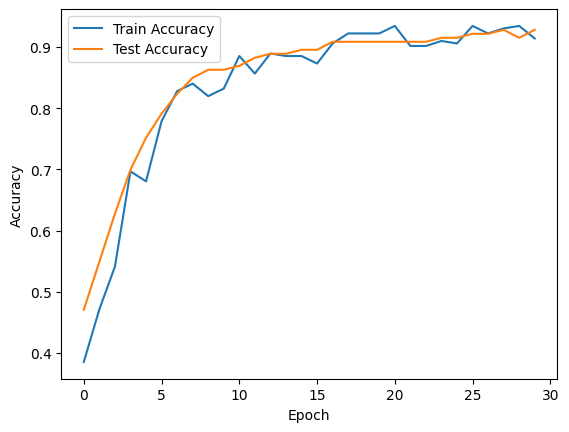

In [40]:
plt.plot(train_accuracy_hist, label='Train Accuracy')
plt.plot(test_accuracy_hist, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

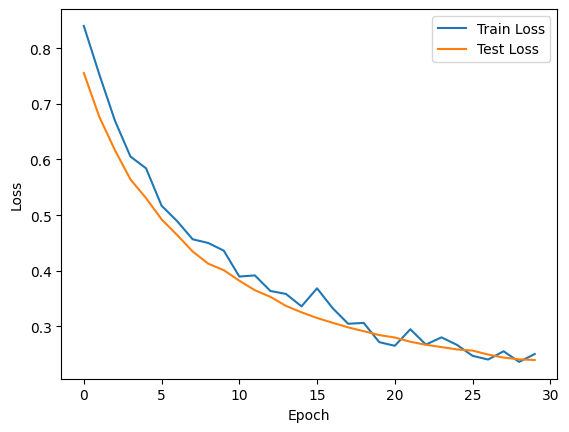

In [41]:
plt.plot(train_loss_hist, label='Train Loss')
plt.plot(test_loss_hist, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

We can observe the model to be performing well as the train and test losses are decreasing and the train and test accuracies are increasing with each epoch. After 30 epochs, the model was able to achieve a test accuracy of $92.81\%$.

\newpage

## Using ResNet-18 as a feature extractor

In [42]:
resnet_model = torchvision.models.resnet18(weights = 'IMAGENET1K_V1').to(device) # We need to reobtain the model as we have modified it previously
resnet_model.fc = nn.Linear(512, len(classes_hymenoptera)).to(device)
for param in resnet_model.parameters():
    param.requires_grad = False

for param in resnet_model.fc.parameters():
    param.requires_grad = True

In [43]:
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet_model.parameters(), lr=0.001)
iterations = 30

In [44]:
print(summary(resnet_model, input_size=(batch_size, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"]))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
ResNet                                   [32, 3, 224, 224]         [32, 2]                   --                        Partial
├─Conv2d: 1-1                            [32, 3, 224, 224]         [32, 64, 112, 112]        (9,408)                   False
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        [32, 64, 112, 112]        (128)                     False
├─ReLU: 1-3                              [32, 64, 112, 112]        [32, 64, 112, 112]        --                        --
├─MaxPool2d: 1-4                         [32, 64, 112, 112]        [32, 64, 56, 56]          --                        --
├─Sequential: 1-5                        [32, 64, 56, 56]          [32, 64, 56, 56]          --                        False
│    └─BasicBlock: 2-1                   [32, 64, 56, 56]          [32, 64, 56, 56]          --                        False


In [45]:
train_accuracy_hist, test_accuracy_hist, train_loss_hist, test_loss_hist = train(resnet_model, trainloader_hymenoptera, testloader_hymenoptera, iterations, optimizer, loss, device)

Epoch 1 / 30, Train Loss: 0.6621313095092773, Test Loss: 0.6414272069931031, Train Accuracy: 0.5860655737704918, Test Accuracy: 0.5882352941176471
Epoch 2 / 30, Train Loss: 0.6426210552453995, Test Loss: 0.6073173403739929, Train Accuracy: 0.639344262295082, Test Accuracy: 0.6797385620915033
Epoch 3 / 30, Train Loss: 0.6067900285124779, Test Loss: 0.5845212697982788, Train Accuracy: 0.6844262295081968, Test Accuracy: 0.7124183006535948
Epoch 4 / 30, Train Loss: 0.5837375596165657, Test Loss: 0.5580122470855713, Train Accuracy: 0.7213114754098361, Test Accuracy: 0.738562091503268
Epoch 5 / 30, Train Loss: 0.5456314645707607, Test Loss: 0.5373104989528656, Train Accuracy: 0.7622950819672131, Test Accuracy: 0.8104575163398693
Epoch 6 / 30, Train Loss: 0.5299510098993778, Test Loss: 0.510362184047699, Train Accuracy: 0.7786885245901639, Test Accuracy: 0.8235294117647058
Epoch 7 / 30, Train Loss: 0.5166481956839561, Test Loss: 0.49135775566101075, Train Accuracy: 0.7909836065573771, Test Ac

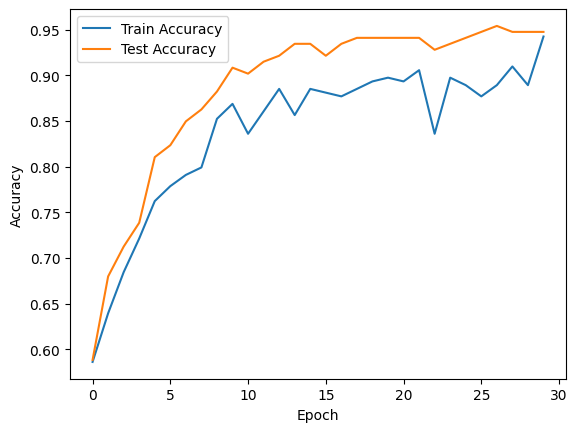

In [46]:
plt.plot(train_accuracy_hist, label='Train Accuracy')
plt.plot(test_accuracy_hist, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

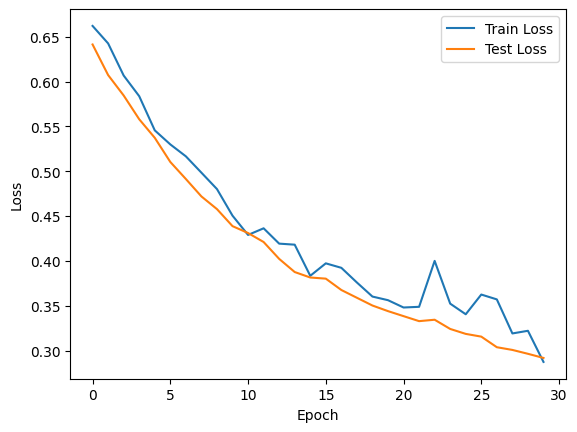

In [47]:
plt.plot(train_loss_hist, label='Train Loss')
plt.plot(test_loss_hist, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

When using the model as a feature extractor, the performance is still very good. After 30 epochs, the model was able to achieve a test accuracy of $94.77\%$ which exceeds the performance when it was finetuned. However, the accuracy on the training set is lower than when the model was finetuned. This is likely due to the model overfitting when it was finetuned. This behaviour was repeatably observed.